# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The `extract_features`
function takes a set of mages and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = 1 / 10**np.arange(1,10,1)
regularization_strengths =  np.append(1 / 10**np.arange(1,7,1), np.arange(10,100,10))
regularization_strengths = np.append(regularization_strengths, np.arange(100,2000,100))
print('learning_rates: ', learning_rates)
print('regularization_strengths: ', regularization_strengths)

best_val = 0
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

from copy import deepcopy
from math import ceil

batch_size = 200
num_epcho = 20
num_train = X_train.shape[0]
num_iters = num_epcho * ceil(num_train/batch_size)
loss_hist_all = {}
results = {}

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()  # define a new object of class: LinearSVM
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                              num_iters=num_iters, batch_size=batch_size, verbose=False)
        
        # keep trace of hyperparameters tunning
        setting = (lr, reg)
        loss_hist_all[setting] = loss_hist
        
        # predict labels on training and validation set
        y_train_pred = svm.predict(X_train_feats)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = svm.predict(X_val_feats)
        val_accuracy = np.mean(y_val == y_val_pred)
        print('learning_rate: %e, reg: %e' % (lr,reg))
        print('             training accuracy: %f' % (train_accuracy, ))
        print('             validation accuracy: %f' % (val_accuracy, ))
        
        # update the best parameters and save the best SVM classifier
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_setting = (lr,reg)
            best_svm = deepcopy(svm) # copy an instance of class
        print('----best: lr %e reg %e val_acc %f' % (best_setting[0],
                                                    best_setting[1],
                                                    best_val))
        print()
        
        # save result
        key = (lr,reg)
        results[key] = (train_accuracy, val_accuracy)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates:  [1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08 1.e-09]
regularization_strengths:  [1.0e-01 1.0e-02 1.0e-03 1.0e-04 1.0e-05 1.0e-06 1.0e+01 2.0e+01 3.0e+01
 4.0e+01 5.0e+01 6.0e+01 7.0e+01 8.0e+01 9.0e+01 1.0e+02 2.0e+02 3.0e+02
 4.0e+02 5.0e+02 6.0e+02 7.0e+02 8.0e+02 9.0e+02 1.0e+03 1.1e+03 1.2e+03
 1.3e+03 1.4e+03 1.5e+03 1.6e+03 1.7e+03 1.8e+03 1.9e+03]
learning_rate: 1.000000e-01, reg: 1.000000e-01
             training accuracy: 0.459306
             validation accuracy: 0.463000
----best: lr 1.000000e-01 reg 1.000000e-01 val_acc 0.463000

learning_rate: 1.000000e-01, reg: 1.000000e-02
             training accuracy: 0.483143
             validation accuracy: 0.461000
----best: lr 1.000000e-01 reg 1.000000e-01 val_acc 0.463000

learning_rate: 1.000000e-01, reg: 1.000000e-03
             training accuracy: 0.486878
             validation accuracy: 0.486000
----best: lr 1.000000e-01 reg 1.000000e-03 val_acc 0.486000

learning_rate: 1.000000e-01, reg: 1.00

/home/vincent/stanford_cs231n/assignment1/cs231n/classifiers/linear_svm.py:99: RuntimeWarning: overflow encountered in double_scalars
  loss += reg * np.sum(W * W)  # add reg loss
/home/vincent/anaconda3/envs/cs231n_1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/vincent/stanford_cs231n/assignment1/cs231n/classifiers/linear_svm.py:99: RuntimeWarning: overflow encountered in multiply
  loss += reg * np.sum(W * W)  # add reg loss
/home/vincent/stanford_cs231n/assignment1/cs231n/classifiers/linear_svm.py:91: RuntimeWarning: overflow encountered in subtract
  margin_tmp = scores - correct_class_score + 1
/home/vincent/stanford_cs231n/assignment1/cs231n/classifiers/linear_svm.py:120: RuntimeWarning: overflow encountered in multiply
  dW += 2 * reg * W
/home/vincent/stanford_cs231n/assignment1/cs231n/classifiers/linear_svm.py:91: RuntimeWarning: invalid value encountere

learning_rate: 1.000000e-01, reg: 2.000000e+01
             training accuracy: 0.100265
             validation accuracy: 0.087000
----best: lr 1.000000e-01 reg 1.000000e-04 val_acc 0.487000

learning_rate: 1.000000e-01, reg: 3.000000e+01
             training accuracy: 0.100265
             validation accuracy: 0.087000
----best: lr 1.000000e-01 reg 1.000000e-04 val_acc 0.487000

learning_rate: 1.000000e-01, reg: 4.000000e+01
             training accuracy: 0.100265
             validation accuracy: 0.087000
----best: lr 1.000000e-01 reg 1.000000e-04 val_acc 0.487000

learning_rate: 1.000000e-01, reg: 5.000000e+01
             training accuracy: 0.100265
             validation accuracy: 0.087000
----best: lr 1.000000e-01 reg 1.000000e-04 val_acc 0.487000

learning_rate: 1.000000e-01, reg: 6.000000e+01
             training accuracy: 0.100265
             validation accuracy: 0.087000
----best: lr 1.000000e-01 reg 1.000000e-04 val_acc 0.487000

learning_rate: 1.000000e-01, reg: 7.0000

learning_rate: 1.000000e-02, reg: 2.000000e+02
             training accuracy: 0.100265
             validation accuracy: 0.087000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-02, reg: 3.000000e+02
             training accuracy: 0.100265
             validation accuracy: 0.087000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-02, reg: 4.000000e+02
             training accuracy: 0.100265
             validation accuracy: 0.087000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-02, reg: 5.000000e+02
             training accuracy: 0.100265
             validation accuracy: 0.087000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-02, reg: 6.000000e+02
             training accuracy: 0.100265
             validation accuracy: 0.087000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-02, reg: 7.0000

learning_rate: 1.000000e-03, reg: 1.100000e+03
             training accuracy: 0.100265
             validation accuracy: 0.087000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-03, reg: 1.200000e+03
             training accuracy: 0.100265
             validation accuracy: 0.087000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-03, reg: 1.300000e+03
             training accuracy: 0.100265
             validation accuracy: 0.087000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-03, reg: 1.400000e+03
             training accuracy: 0.100265
             validation accuracy: 0.087000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-03, reg: 1.500000e+03
             training accuracy: 0.100265
             validation accuracy: 0.087000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-03, reg: 1.6000

learning_rate: 1.000000e-05, reg: 1.000000e-01
             training accuracy: 0.421020
             validation accuracy: 0.424000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-05, reg: 1.000000e-02
             training accuracy: 0.421204
             validation accuracy: 0.424000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-05, reg: 1.000000e-03
             training accuracy: 0.420122
             validation accuracy: 0.424000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-05, reg: 1.000000e-04
             training accuracy: 0.418755
             validation accuracy: 0.424000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-05, reg: 1.000000e-05
             training accuracy: 0.419633
             validation accuracy: 0.428000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-05, reg: 1.0000

learning_rate: 1.000000e-06, reg: 4.000000e+01
             training accuracy: 0.382918
             validation accuracy: 0.386000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-06, reg: 5.000000e+01
             training accuracy: 0.384714
             validation accuracy: 0.379000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-06, reg: 6.000000e+01
             training accuracy: 0.382184
             validation accuracy: 0.374000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-06, reg: 7.000000e+01
             training accuracy: 0.393510
             validation accuracy: 0.403000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-06, reg: 8.000000e+01
             training accuracy: 0.390102
             validation accuracy: 0.410000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-06, reg: 9.0000

learning_rate: 1.000000e-07, reg: 4.000000e+02
             training accuracy: 0.140163
             validation accuracy: 0.144000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-07, reg: 5.000000e+02
             training accuracy: 0.173633
             validation accuracy: 0.176000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-07, reg: 6.000000e+02
             training accuracy: 0.195265
             validation accuracy: 0.195000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-07, reg: 7.000000e+02
             training accuracy: 0.174959
             validation accuracy: 0.191000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-07, reg: 8.000000e+02
             training accuracy: 0.193959
             validation accuracy: 0.205000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-07, reg: 9.0000

learning_rate: 1.000000e-08, reg: 1.300000e+03
             training accuracy: 0.080327
             validation accuracy: 0.074000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-08, reg: 1.400000e+03
             training accuracy: 0.093245
             validation accuracy: 0.083000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-08, reg: 1.500000e+03
             training accuracy: 0.119204
             validation accuracy: 0.132000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-08, reg: 1.600000e+03
             training accuracy: 0.103612
             validation accuracy: 0.102000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-08, reg: 1.700000e+03
             training accuracy: 0.092510
             validation accuracy: 0.093000
----best: lr 1.000000e-02 reg 1.000000e-03 val_acc 0.505000

learning_rate: 1.000000e-08, reg: 1.8000

In [6]:
# Print out results.
# for lr, reg in sorted(results):
#     train_accuracy, val_accuracy = results[(lr, reg)]
#     print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
#                 lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

best validation accuracy achieved during cross-validation: 0.505000


In [7]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.489


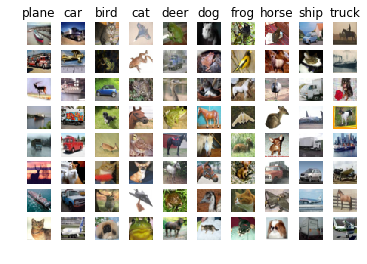

In [8]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$




## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [9]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [19]:
from cs231n.classifiers.neural_net import TwoLayerNet

loss_hist_all = {}
train_hist_all = {}
val_hist_all = {}
results = {}
best_net = None
best_val = 0

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

learning_rates = 1 / 10**np.arange(1,10,1)
regularization_strengths =  np.append(1 / 10**np.arange(1,7,1), np.arange(10,100,10))
regularization_strengths = np.append(regularization_strengths, np.arange(100,2000,100))
hidden_dim = np.arange(50,800,50)
print('hidden_dim: ', hidden_dim)
print('learning_rates: ', learning_rates)
print('regularization_strengths: ', regularization_strengths)

input_dim = X_train_feats.shape[1]
num_classes = 10
lr_decay = 0.95
batch_size = 200
num_epcho = 20
num_train = X_train.shape[0]
num_iters = num_epcho * ceil(num_train/batch_size)


for hidden in hidden_dim:
    for lr in learning_rates:
        for reg in regularization_strengths:
            net = TwoLayerNet(input_dim, hidden, num_classes)  # define a new object of class: TwoLayerNet
            stat = net.train(X_train_feats, y_train, X_val_feats, y_val, lr, lr_decay, reg,
                              num_iters, batch_size, verbose=False)
            loss_hist = stat['loss_history']
            train_acc_hist = stat['train_acc_history']
            val_acc_hist = stat['val_acc_history']
            
            # keep trace of hyperparameters tunning
            setting = (hidden, lr, reg)
            loss_hist_all[setting] = loss_hist
            train_hist_all[setting] = train_acc_hist
            val_hist_all[setting] = val_acc_hist
            
            # best val_acc and corresponding train_acc
            val_acc = val_acc_hist[-1]
            train_acc = train_acc_hist[-1]
            print('hidden layer size: %d learning_rate: %e, reg: %e' % (hidden, lr,reg))
            print('             training accuracy: %f' % (train_acc, ))
            print('             validation accuracy: %f' % (val_acc, ))
        
            # update the best parameters and save the best SVM classifier
            if val_acc > best_val:
                best_val = val_acc
                best_setting = (hidden, lr,reg)
                best_net = deepcopy(net) # copy an instance of class
            print('----best: hidden size: %d lr %e reg %e val_acc %f' % (best_setting[0],
                                                    best_setting[1], best_setting[2],
                                                    best_val))
            print()
        
            # save result
            key = (hidden,lr,reg)
            results[key] = (train_acc, val_acc)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


hidden_dim:  [ 50 100 150 200 250 300 350 400 450 500 550 600 650 700 750]
learning_rates:  [1.e-01 1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08 1.e-09]
regularization_strengths:  [1.0e-01 1.0e-02 1.0e-03 1.0e-04 1.0e-05 1.0e-06 1.0e+01 2.0e+01 3.0e+01
 4.0e+01 5.0e+01 6.0e+01 7.0e+01 8.0e+01 9.0e+01 1.0e+02 2.0e+02 3.0e+02
 4.0e+02 5.0e+02 6.0e+02 7.0e+02 8.0e+02 9.0e+02 1.0e+03 1.1e+03 1.2e+03
 1.3e+03 1.4e+03 1.5e+03 1.6e+03 1.7e+03 1.8e+03 1.9e+03]
hidden layer size: 50 learning_rate: 1.000000e-01, reg: 1.000000e-01
             training accuracy: 0.390000
             validation accuracy: 0.310000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-01 val_acc 0.310000

hidden layer size: 50 learning_rate: 1.000000e-01, reg: 1.000000e-02
             training accuracy: 0.570000
             validation accuracy: 0.506000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-02 val_acc 0.506000

hidden layer size: 50 learning_rate: 1.000000e-01, reg: 1.000000e-03
          

hidden layer size: 50 learning_rate: 1.000000e-02, reg: 1.000000e-01
             training accuracy: 0.105000
             validation accuracy: 0.087000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-02, reg: 1.000000e-02
             training accuracy: 0.265000
             validation accuracy: 0.282000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-02, reg: 1.000000e-03
             training accuracy: 0.320000
             validation accuracy: 0.283000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-02, reg: 1.000000e-04
             training accuracy: 0.315000
             validation accuracy: 0.295000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-02, reg: 1.000000e-05
           

hidden layer size: 50 learning_rate: 1.000000e-03, reg: 1.000000e-03
             training accuracy: 0.090000
             validation accuracy: 0.078000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-03, reg: 1.000000e-04
             training accuracy: 0.095000
             validation accuracy: 0.079000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-03, reg: 1.000000e-05
             training accuracy: 0.105000
             validation accuracy: 0.079000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-03, reg: 1.000000e-06
             training accuracy: 0.080000
             validation accuracy: 0.079000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-03, reg: 1.000000e+01
           

hidden layer size: 50 learning_rate: 1.000000e-04, reg: 1.000000e-05
             training accuracy: 0.075000
             validation accuracy: 0.079000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-04, reg: 1.000000e-06
             training accuracy: 0.085000
             validation accuracy: 0.079000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-04, reg: 1.000000e+01
             training accuracy: 0.075000
             validation accuracy: 0.087000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-04, reg: 2.000000e+01
             training accuracy: 0.105000
             validation accuracy: 0.098000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-04, reg: 3.000000e+01
           

hidden layer size: 50 learning_rate: 1.000000e-05, reg: 1.000000e+01
             training accuracy: 0.110000
             validation accuracy: 0.079000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-05, reg: 2.000000e+01
             training accuracy: 0.105000
             validation accuracy: 0.078000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-05, reg: 3.000000e+01
             training accuracy: 0.115000
             validation accuracy: 0.079000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-05, reg: 4.000000e+01
             training accuracy: 0.085000
             validation accuracy: 0.098000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-05, reg: 5.000000e+01
           

hidden layer size: 50 learning_rate: 1.000000e-06, reg: 3.000000e+01
             training accuracy: 0.100000
             validation accuracy: 0.087000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-06, reg: 4.000000e+01
             training accuracy: 0.060000
             validation accuracy: 0.080000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-06, reg: 5.000000e+01
             training accuracy: 0.095000
             validation accuracy: 0.077000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-06, reg: 6.000000e+01
             training accuracy: 0.085000
             validation accuracy: 0.078000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-06, reg: 7.000000e+01
           

hidden layer size: 50 learning_rate: 1.000000e-07, reg: 5.000000e+01
             training accuracy: 0.080000
             validation accuracy: 0.096000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-07, reg: 6.000000e+01
             training accuracy: 0.075000
             validation accuracy: 0.100000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-07, reg: 7.000000e+01
             training accuracy: 0.135000
             validation accuracy: 0.115000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-07, reg: 8.000000e+01
             training accuracy: 0.070000
             validation accuracy: 0.089000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-07, reg: 9.000000e+01
           

hidden layer size: 50 learning_rate: 1.000000e-08, reg: 7.000000e+01
             training accuracy: 0.055000
             validation accuracy: 0.112000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-08, reg: 8.000000e+01
             training accuracy: 0.070000
             validation accuracy: 0.093000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-08, reg: 9.000000e+01
             training accuracy: 0.085000
             validation accuracy: 0.087000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-08, reg: 1.000000e+02
             training accuracy: 0.085000
             validation accuracy: 0.106000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-08, reg: 2.000000e+02
           

hidden layer size: 50 learning_rate: 1.000000e-09, reg: 9.000000e+01
             training accuracy: 0.095000
             validation accuracy: 0.055000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-09, reg: 1.000000e+02
             training accuracy: 0.085000
             validation accuracy: 0.110000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-09, reg: 2.000000e+02
             training accuracy: 0.085000
             validation accuracy: 0.083000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-09, reg: 3.000000e+02
             training accuracy: 0.110000
             validation accuracy: 0.117000
----best: hidden size: 50 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.566000

hidden layer size: 50 learning_rate: 1.000000e-09, reg: 4.000000e+02
           

hidden layer size: 100 learning_rate: 1.000000e-01, reg: 2.000000e+02
             training accuracy: 0.075000
             validation accuracy: 0.087000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-01, reg: 3.000000e+02
             training accuracy: 0.095000
             validation accuracy: 0.087000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-01, reg: 4.000000e+02
             training accuracy: 0.095000
             validation accuracy: 0.087000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-01, reg: 5.000000e+02
             training accuracy: 0.090000
             validation accuracy: 0.087000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-01, reg: 6.000000e+02
  

hidden layer size: 100 learning_rate: 1.000000e-02, reg: 4.000000e+02
             training accuracy: 0.080000
             validation accuracy: 0.087000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-02, reg: 5.000000e+02
             training accuracy: 0.075000
             validation accuracy: 0.087000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-02, reg: 6.000000e+02
             training accuracy: 0.130000
             validation accuracy: 0.087000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-02, reg: 7.000000e+02
             training accuracy: 0.115000
             validation accuracy: 0.087000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-02, reg: 8.000000e+02
  

hidden layer size: 100 learning_rate: 1.000000e-03, reg: 6.000000e+02
             training accuracy: 0.100000
             validation accuracy: 0.079000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-03, reg: 7.000000e+02
             training accuracy: 0.115000
             validation accuracy: 0.078000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-03, reg: 8.000000e+02
             training accuracy: 0.105000
             validation accuracy: 0.079000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-03, reg: 9.000000e+02
             training accuracy: 0.140000
             validation accuracy: 0.078000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-03, reg: 1.000000e+03
  

hidden layer size: 100 learning_rate: 1.000000e-04, reg: 8.000000e+02
             training accuracy: 0.120000
             validation accuracy: 0.078000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-04, reg: 9.000000e+02
             training accuracy: 0.125000
             validation accuracy: 0.078000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-04, reg: 1.000000e+03
             training accuracy: 0.060000
             validation accuracy: 0.087000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-04, reg: 1.100000e+03
             training accuracy: 0.060000
             validation accuracy: 0.078000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-04, reg: 1.200000e+03
  

hidden layer size: 100 learning_rate: 1.000000e-05, reg: 1.000000e+03
             training accuracy: 0.050000
             validation accuracy: 0.079000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-05, reg: 1.100000e+03
             training accuracy: 0.110000
             validation accuracy: 0.078000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-05, reg: 1.200000e+03
             training accuracy: 0.080000
             validation accuracy: 0.079000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-05, reg: 1.300000e+03
             training accuracy: 0.120000
             validation accuracy: 0.079000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-05, reg: 1.400000e+03
  

hidden layer size: 100 learning_rate: 1.000000e-06, reg: 1.200000e+03
             training accuracy: 0.100000
             validation accuracy: 0.079000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-06, reg: 1.300000e+03
             training accuracy: 0.140000
             validation accuracy: 0.079000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-06, reg: 1.400000e+03
             training accuracy: 0.090000
             validation accuracy: 0.078000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-06, reg: 1.500000e+03
             training accuracy: 0.125000
             validation accuracy: 0.087000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-06, reg: 1.600000e+03
  

hidden layer size: 100 learning_rate: 1.000000e-07, reg: 1.400000e+03
             training accuracy: 0.115000
             validation accuracy: 0.090000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-07, reg: 1.500000e+03
             training accuracy: 0.070000
             validation accuracy: 0.087000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-07, reg: 1.600000e+03
             training accuracy: 0.155000
             validation accuracy: 0.097000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-07, reg: 1.700000e+03
             training accuracy: 0.105000
             validation accuracy: 0.102000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-07, reg: 1.800000e+03
  

hidden layer size: 100 learning_rate: 1.000000e-08, reg: 1.600000e+03
             training accuracy: 0.120000
             validation accuracy: 0.096000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-08, reg: 1.700000e+03
             training accuracy: 0.085000
             validation accuracy: 0.085000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-08, reg: 1.800000e+03
             training accuracy: 0.125000
             validation accuracy: 0.097000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-08, reg: 1.900000e+03
             training accuracy: 0.070000
             validation accuracy: 0.099000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-09, reg: 1.000000e-01
  

hidden layer size: 100 learning_rate: 1.000000e-09, reg: 1.800000e+03
             training accuracy: 0.100000
             validation accuracy: 0.100000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 100 learning_rate: 1.000000e-09, reg: 1.900000e+03
             training accuracy: 0.075000
             validation accuracy: 0.093000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 150 learning_rate: 1.000000e-01, reg: 1.000000e-01
             training accuracy: 0.290000
             validation accuracy: 0.326000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 150 learning_rate: 1.000000e-01, reg: 1.000000e-02
             training accuracy: 0.545000
             validation accuracy: 0.516000
----best: hidden size: 100 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.575000

hidden layer size: 150 learning_rate: 1.000000e-01, reg: 1.000000e-03
  

hidden layer size: 150 learning_rate: 1.000000e-02, reg: 1.000000e-01
             training accuracy: 0.145000
             validation accuracy: 0.141000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-02, reg: 1.000000e-02
             training accuracy: 0.205000
             validation accuracy: 0.297000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-02, reg: 1.000000e-03
             training accuracy: 0.315000
             validation accuracy: 0.297000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-02, reg: 1.000000e-04
             training accuracy: 0.310000
             validation accuracy: 0.296000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-02, reg: 1.000000e-05
  

hidden layer size: 150 learning_rate: 1.000000e-03, reg: 1.000000e-03
             training accuracy: 0.170000
             validation accuracy: 0.108000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-03, reg: 1.000000e-04
             training accuracy: 0.130000
             validation accuracy: 0.087000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-03, reg: 1.000000e-05
             training accuracy: 0.125000
             validation accuracy: 0.079000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-03, reg: 1.000000e-06
             training accuracy: 0.065000
             validation accuracy: 0.078000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-03, reg: 1.000000e+01
  

hidden layer size: 150 learning_rate: 1.000000e-04, reg: 1.000000e-05
             training accuracy: 0.075000
             validation accuracy: 0.079000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-04, reg: 1.000000e-06
             training accuracy: 0.105000
             validation accuracy: 0.079000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-04, reg: 1.000000e+01
             training accuracy: 0.125000
             validation accuracy: 0.078000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-04, reg: 2.000000e+01
             training accuracy: 0.105000
             validation accuracy: 0.087000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-04, reg: 3.000000e+01
  

hidden layer size: 150 learning_rate: 1.000000e-05, reg: 1.000000e+01
             training accuracy: 0.120000
             validation accuracy: 0.078000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-05, reg: 2.000000e+01
             training accuracy: 0.150000
             validation accuracy: 0.079000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-05, reg: 3.000000e+01
             training accuracy: 0.100000
             validation accuracy: 0.087000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-05, reg: 4.000000e+01
             training accuracy: 0.100000
             validation accuracy: 0.098000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-05, reg: 5.000000e+01
  

hidden layer size: 150 learning_rate: 1.000000e-06, reg: 3.000000e+01
             training accuracy: 0.085000
             validation accuracy: 0.081000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-06, reg: 4.000000e+01
             training accuracy: 0.125000
             validation accuracy: 0.088000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-06, reg: 5.000000e+01
             training accuracy: 0.155000
             validation accuracy: 0.131000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-06, reg: 6.000000e+01
             training accuracy: 0.105000
             validation accuracy: 0.079000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-06, reg: 7.000000e+01
  

hidden layer size: 150 learning_rate: 1.000000e-07, reg: 5.000000e+01
             training accuracy: 0.095000
             validation accuracy: 0.099000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-07, reg: 6.000000e+01
             training accuracy: 0.105000
             validation accuracy: 0.089000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-07, reg: 7.000000e+01
             training accuracy: 0.095000
             validation accuracy: 0.090000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-07, reg: 8.000000e+01
             training accuracy: 0.100000
             validation accuracy: 0.124000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-07, reg: 9.000000e+01
  

hidden layer size: 150 learning_rate: 1.000000e-08, reg: 7.000000e+01
             training accuracy: 0.075000
             validation accuracy: 0.099000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-08, reg: 8.000000e+01
             training accuracy: 0.130000
             validation accuracy: 0.103000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-08, reg: 9.000000e+01
             training accuracy: 0.080000
             validation accuracy: 0.115000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-08, reg: 1.000000e+02
             training accuracy: 0.090000
             validation accuracy: 0.099000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-08, reg: 2.000000e+02
  

hidden layer size: 150 learning_rate: 1.000000e-09, reg: 9.000000e+01
             training accuracy: 0.125000
             validation accuracy: 0.089000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-09, reg: 1.000000e+02
             training accuracy: 0.070000
             validation accuracy: 0.103000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-09, reg: 2.000000e+02
             training accuracy: 0.120000
             validation accuracy: 0.100000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-09, reg: 3.000000e+02
             training accuracy: 0.055000
             validation accuracy: 0.085000
----best: hidden size: 150 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.577000

hidden layer size: 150 learning_rate: 1.000000e-09, reg: 4.000000e+02
  

hidden layer size: 200 learning_rate: 1.000000e-01, reg: 2.000000e+02
             training accuracy: 0.110000
             validation accuracy: 0.087000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-01, reg: 3.000000e+02
             training accuracy: 0.110000
             validation accuracy: 0.087000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-01, reg: 4.000000e+02
             training accuracy: 0.105000
             validation accuracy: 0.087000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-01, reg: 5.000000e+02
             training accuracy: 0.145000
             validation accuracy: 0.087000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-01, reg: 6.000000e+02
  

hidden layer size: 200 learning_rate: 1.000000e-02, reg: 4.000000e+02
             training accuracy: 0.090000
             validation accuracy: 0.087000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-02, reg: 5.000000e+02
             training accuracy: 0.105000
             validation accuracy: 0.087000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-02, reg: 6.000000e+02
             training accuracy: 0.100000
             validation accuracy: 0.087000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-02, reg: 7.000000e+02
             training accuracy: 0.115000
             validation accuracy: 0.087000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-02, reg: 8.000000e+02
  

hidden layer size: 200 learning_rate: 1.000000e-03, reg: 6.000000e+02
             training accuracy: 0.090000
             validation accuracy: 0.078000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-03, reg: 7.000000e+02
             training accuracy: 0.060000
             validation accuracy: 0.079000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-03, reg: 8.000000e+02
             training accuracy: 0.115000
             validation accuracy: 0.078000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-03, reg: 9.000000e+02
             training accuracy: 0.080000
             validation accuracy: 0.112000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-03, reg: 1.000000e+03
  

hidden layer size: 200 learning_rate: 1.000000e-04, reg: 8.000000e+02
             training accuracy: 0.105000
             validation accuracy: 0.078000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-04, reg: 9.000000e+02
             training accuracy: 0.120000
             validation accuracy: 0.098000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-04, reg: 1.000000e+03
             training accuracy: 0.090000
             validation accuracy: 0.078000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-04, reg: 1.100000e+03
             training accuracy: 0.125000
             validation accuracy: 0.079000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-04, reg: 1.200000e+03
  

hidden layer size: 200 learning_rate: 1.000000e-05, reg: 1.000000e+03
             training accuracy: 0.095000
             validation accuracy: 0.079000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-05, reg: 1.100000e+03
             training accuracy: 0.090000
             validation accuracy: 0.079000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-05, reg: 1.200000e+03
             training accuracy: 0.105000
             validation accuracy: 0.078000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-05, reg: 1.300000e+03
             training accuracy: 0.110000
             validation accuracy: 0.079000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-05, reg: 1.400000e+03
  

hidden layer size: 200 learning_rate: 1.000000e-06, reg: 1.200000e+03
             training accuracy: 0.080000
             validation accuracy: 0.087000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-06, reg: 1.300000e+03
             training accuracy: 0.115000
             validation accuracy: 0.078000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-06, reg: 1.400000e+03
             training accuracy: 0.065000
             validation accuracy: 0.079000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-06, reg: 1.500000e+03
             training accuracy: 0.130000
             validation accuracy: 0.078000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-06, reg: 1.600000e+03
  

hidden layer size: 200 learning_rate: 1.000000e-07, reg: 1.400000e+03
             training accuracy: 0.105000
             validation accuracy: 0.082000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-07, reg: 1.500000e+03
             training accuracy: 0.100000
             validation accuracy: 0.113000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-07, reg: 1.600000e+03
             training accuracy: 0.085000
             validation accuracy: 0.089000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-07, reg: 1.700000e+03
             training accuracy: 0.125000
             validation accuracy: 0.073000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-07, reg: 1.800000e+03
  

hidden layer size: 200 learning_rate: 1.000000e-08, reg: 1.600000e+03
             training accuracy: 0.125000
             validation accuracy: 0.093000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-08, reg: 1.700000e+03
             training accuracy: 0.085000
             validation accuracy: 0.116000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-08, reg: 1.800000e+03
             training accuracy: 0.125000
             validation accuracy: 0.091000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-08, reg: 1.900000e+03
             training accuracy: 0.095000
             validation accuracy: 0.087000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-09, reg: 1.000000e-01
  

hidden layer size: 200 learning_rate: 1.000000e-09, reg: 1.800000e+03
             training accuracy: 0.130000
             validation accuracy: 0.089000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 200 learning_rate: 1.000000e-09, reg: 1.900000e+03
             training accuracy: 0.055000
             validation accuracy: 0.087000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 250 learning_rate: 1.000000e-01, reg: 1.000000e-01
             training accuracy: 0.380000
             validation accuracy: 0.311000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 250 learning_rate: 1.000000e-01, reg: 1.000000e-02
             training accuracy: 0.500000
             validation accuracy: 0.524000
----best: hidden size: 200 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.584000

hidden layer size: 250 learning_rate: 1.000000e-01, reg: 1.000000e-03
  

hidden layer size: 250 learning_rate: 1.000000e-02, reg: 1.000000e-01
             training accuracy: 0.145000
             validation accuracy: 0.115000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-02, reg: 1.000000e-02
             training accuracy: 0.310000
             validation accuracy: 0.296000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-02, reg: 1.000000e-03
             training accuracy: 0.295000
             validation accuracy: 0.311000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-02, reg: 1.000000e-04
             training accuracy: 0.310000
             validation accuracy: 0.306000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-02, reg: 1.000000e-05
  

hidden layer size: 250 learning_rate: 1.000000e-03, reg: 1.000000e-03
             training accuracy: 0.115000
             validation accuracy: 0.078000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-03, reg: 1.000000e-04
             training accuracy: 0.095000
             validation accuracy: 0.105000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-03, reg: 1.000000e-05
             training accuracy: 0.120000
             validation accuracy: 0.078000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-03, reg: 1.000000e-06
             training accuracy: 0.115000
             validation accuracy: 0.078000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-03, reg: 1.000000e+01
  

hidden layer size: 250 learning_rate: 1.000000e-04, reg: 1.000000e-05
             training accuracy: 0.100000
             validation accuracy: 0.079000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-04, reg: 1.000000e-06
             training accuracy: 0.095000
             validation accuracy: 0.078000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-04, reg: 1.000000e+01
             training accuracy: 0.115000
             validation accuracy: 0.079000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-04, reg: 2.000000e+01
             training accuracy: 0.130000
             validation accuracy: 0.079000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-04, reg: 3.000000e+01
  

hidden layer size: 250 learning_rate: 1.000000e-05, reg: 1.000000e+01
             training accuracy: 0.140000
             validation accuracy: 0.087000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-05, reg: 2.000000e+01
             training accuracy: 0.085000
             validation accuracy: 0.087000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-05, reg: 3.000000e+01
             training accuracy: 0.060000
             validation accuracy: 0.107000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-05, reg: 4.000000e+01
             training accuracy: 0.100000
             validation accuracy: 0.079000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-05, reg: 5.000000e+01
  

hidden layer size: 250 learning_rate: 1.000000e-06, reg: 3.000000e+01
             training accuracy: 0.110000
             validation accuracy: 0.096000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-06, reg: 4.000000e+01
             training accuracy: 0.125000
             validation accuracy: 0.084000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-06, reg: 5.000000e+01
             training accuracy: 0.080000
             validation accuracy: 0.095000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-06, reg: 6.000000e+01
             training accuracy: 0.090000
             validation accuracy: 0.092000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-06, reg: 7.000000e+01
  

hidden layer size: 250 learning_rate: 1.000000e-07, reg: 5.000000e+01
             training accuracy: 0.110000
             validation accuracy: 0.109000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-07, reg: 6.000000e+01
             training accuracy: 0.120000
             validation accuracy: 0.138000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-07, reg: 7.000000e+01
             training accuracy: 0.065000
             validation accuracy: 0.070000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-07, reg: 8.000000e+01
             training accuracy: 0.100000
             validation accuracy: 0.110000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-07, reg: 9.000000e+01
  

hidden layer size: 250 learning_rate: 1.000000e-08, reg: 7.000000e+01
             training accuracy: 0.120000
             validation accuracy: 0.100000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-08, reg: 8.000000e+01
             training accuracy: 0.105000
             validation accuracy: 0.105000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-08, reg: 9.000000e+01
             training accuracy: 0.085000
             validation accuracy: 0.094000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-08, reg: 1.000000e+02
             training accuracy: 0.095000
             validation accuracy: 0.113000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-08, reg: 2.000000e+02
  

hidden layer size: 250 learning_rate: 1.000000e-09, reg: 9.000000e+01
             training accuracy: 0.090000
             validation accuracy: 0.081000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-09, reg: 1.000000e+02
             training accuracy: 0.110000
             validation accuracy: 0.107000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-09, reg: 2.000000e+02
             training accuracy: 0.080000
             validation accuracy: 0.094000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-09, reg: 3.000000e+02
             training accuracy: 0.085000
             validation accuracy: 0.130000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 250 learning_rate: 1.000000e-09, reg: 4.000000e+02
  

hidden layer size: 300 learning_rate: 1.000000e-01, reg: 2.000000e+02
             training accuracy: 0.095000
             validation accuracy: 0.087000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-01, reg: 3.000000e+02
             training accuracy: 0.130000
             validation accuracy: 0.087000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-01, reg: 4.000000e+02
             training accuracy: 0.105000
             validation accuracy: 0.087000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-01, reg: 5.000000e+02
             training accuracy: 0.110000
             validation accuracy: 0.087000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-01, reg: 6.000000e+02
  

hidden layer size: 300 learning_rate: 1.000000e-02, reg: 4.000000e+02
             training accuracy: 0.085000
             validation accuracy: 0.087000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-02, reg: 5.000000e+02
             training accuracy: 0.095000
             validation accuracy: 0.087000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-02, reg: 6.000000e+02
             training accuracy: 0.115000
             validation accuracy: 0.087000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-02, reg: 7.000000e+02
             training accuracy: 0.090000
             validation accuracy: 0.087000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-02, reg: 8.000000e+02
  

hidden layer size: 300 learning_rate: 1.000000e-03, reg: 6.000000e+02
             training accuracy: 0.095000
             validation accuracy: 0.078000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-03, reg: 7.000000e+02
             training accuracy: 0.140000
             validation accuracy: 0.079000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-03, reg: 8.000000e+02
             training accuracy: 0.100000
             validation accuracy: 0.078000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-03, reg: 9.000000e+02
             training accuracy: 0.085000
             validation accuracy: 0.087000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-03, reg: 1.000000e+03
  

hidden layer size: 300 learning_rate: 1.000000e-04, reg: 8.000000e+02
             training accuracy: 0.095000
             validation accuracy: 0.078000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-04, reg: 9.000000e+02
             training accuracy: 0.100000
             validation accuracy: 0.078000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-04, reg: 1.000000e+03
             training accuracy: 0.105000
             validation accuracy: 0.079000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-04, reg: 1.100000e+03
             training accuracy: 0.080000
             validation accuracy: 0.078000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-04, reg: 1.200000e+03
  

hidden layer size: 300 learning_rate: 1.000000e-05, reg: 1.000000e+03
             training accuracy: 0.110000
             validation accuracy: 0.079000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-05, reg: 1.100000e+03
             training accuracy: 0.120000
             validation accuracy: 0.098000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-05, reg: 1.200000e+03
             training accuracy: 0.140000
             validation accuracy: 0.079000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-05, reg: 1.300000e+03
             training accuracy: 0.070000
             validation accuracy: 0.113000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-05, reg: 1.400000e+03
  

hidden layer size: 300 learning_rate: 1.000000e-06, reg: 1.200000e+03
             training accuracy: 0.095000
             validation accuracy: 0.079000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-06, reg: 1.300000e+03
             training accuracy: 0.090000
             validation accuracy: 0.078000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-06, reg: 1.400000e+03
             training accuracy: 0.110000
             validation accuracy: 0.078000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-06, reg: 1.500000e+03
             training accuracy: 0.100000
             validation accuracy: 0.078000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-06, reg: 1.600000e+03
  

hidden layer size: 300 learning_rate: 1.000000e-07, reg: 1.400000e+03
             training accuracy: 0.080000
             validation accuracy: 0.095000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-07, reg: 1.500000e+03
             training accuracy: 0.075000
             validation accuracy: 0.118000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-07, reg: 1.600000e+03
             training accuracy: 0.080000
             validation accuracy: 0.079000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-07, reg: 1.700000e+03
             training accuracy: 0.135000
             validation accuracy: 0.098000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-07, reg: 1.800000e+03
  

hidden layer size: 300 learning_rate: 1.000000e-08, reg: 1.600000e+03
             training accuracy: 0.105000
             validation accuracy: 0.084000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-08, reg: 1.700000e+03
             training accuracy: 0.090000
             validation accuracy: 0.097000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-08, reg: 1.800000e+03
             training accuracy: 0.095000
             validation accuracy: 0.090000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-08, reg: 1.900000e+03
             training accuracy: 0.125000
             validation accuracy: 0.098000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-09, reg: 1.000000e-01
  

hidden layer size: 300 learning_rate: 1.000000e-09, reg: 1.800000e+03
             training accuracy: 0.130000
             validation accuracy: 0.096000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 300 learning_rate: 1.000000e-09, reg: 1.900000e+03
             training accuracy: 0.095000
             validation accuracy: 0.095000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 350 learning_rate: 1.000000e-01, reg: 1.000000e-01
             training accuracy: 0.410000
             validation accuracy: 0.316000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 350 learning_rate: 1.000000e-01, reg: 1.000000e-02
             training accuracy: 0.560000
             validation accuracy: 0.509000
----best: hidden size: 250 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.589000

hidden layer size: 350 learning_rate: 1.000000e-01, reg: 1.000000e-03
  

hidden layer size: 350 learning_rate: 1.000000e-02, reg: 1.000000e-01
             training accuracy: 0.130000
             validation accuracy: 0.171000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-02, reg: 1.000000e-02
             training accuracy: 0.295000
             validation accuracy: 0.291000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-02, reg: 1.000000e-03
             training accuracy: 0.315000
             validation accuracy: 0.311000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-02, reg: 1.000000e-04
             training accuracy: 0.370000
             validation accuracy: 0.311000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-02, reg: 1.000000e-05
  

hidden layer size: 350 learning_rate: 1.000000e-03, reg: 1.000000e-03
             training accuracy: 0.075000
             validation accuracy: 0.079000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-03, reg: 1.000000e-04
             training accuracy: 0.075000
             validation accuracy: 0.078000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-03, reg: 1.000000e-05
             training accuracy: 0.105000
             validation accuracy: 0.079000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-03, reg: 1.000000e-06
             training accuracy: 0.090000
             validation accuracy: 0.078000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-03, reg: 1.000000e+01
  

hidden layer size: 350 learning_rate: 1.000000e-04, reg: 1.000000e-05
             training accuracy: 0.120000
             validation accuracy: 0.078000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-04, reg: 1.000000e-06
             training accuracy: 0.110000
             validation accuracy: 0.078000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-04, reg: 1.000000e+01
             training accuracy: 0.090000
             validation accuracy: 0.087000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-04, reg: 2.000000e+01
             training accuracy: 0.085000
             validation accuracy: 0.098000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-04, reg: 3.000000e+01
  

hidden layer size: 350 learning_rate: 1.000000e-05, reg: 1.000000e+01
             training accuracy: 0.100000
             validation accuracy: 0.108000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-05, reg: 2.000000e+01
             training accuracy: 0.095000
             validation accuracy: 0.078000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-05, reg: 3.000000e+01
             training accuracy: 0.085000
             validation accuracy: 0.079000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-05, reg: 4.000000e+01
             training accuracy: 0.080000
             validation accuracy: 0.079000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-05, reg: 5.000000e+01
  

hidden layer size: 350 learning_rate: 1.000000e-06, reg: 3.000000e+01
             training accuracy: 0.100000
             validation accuracy: 0.087000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-06, reg: 4.000000e+01
             training accuracy: 0.110000
             validation accuracy: 0.078000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-06, reg: 5.000000e+01
             training accuracy: 0.085000
             validation accuracy: 0.097000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-06, reg: 6.000000e+01
             training accuracy: 0.115000
             validation accuracy: 0.087000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-06, reg: 7.000000e+01
  

hidden layer size: 350 learning_rate: 1.000000e-07, reg: 5.000000e+01
             training accuracy: 0.120000
             validation accuracy: 0.126000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-07, reg: 6.000000e+01
             training accuracy: 0.085000
             validation accuracy: 0.086000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-07, reg: 7.000000e+01
             training accuracy: 0.110000
             validation accuracy: 0.120000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-07, reg: 8.000000e+01
             training accuracy: 0.090000
             validation accuracy: 0.094000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-07, reg: 9.000000e+01
  

hidden layer size: 350 learning_rate: 1.000000e-08, reg: 7.000000e+01
             training accuracy: 0.090000
             validation accuracy: 0.098000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-08, reg: 8.000000e+01
             training accuracy: 0.100000
             validation accuracy: 0.100000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-08, reg: 9.000000e+01
             training accuracy: 0.080000
             validation accuracy: 0.091000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-08, reg: 1.000000e+02
             training accuracy: 0.130000
             validation accuracy: 0.112000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-08, reg: 2.000000e+02
  

hidden layer size: 350 learning_rate: 1.000000e-09, reg: 9.000000e+01
             training accuracy: 0.065000
             validation accuracy: 0.098000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-09, reg: 1.000000e+02
             training accuracy: 0.075000
             validation accuracy: 0.093000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-09, reg: 2.000000e+02
             training accuracy: 0.070000
             validation accuracy: 0.120000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-09, reg: 3.000000e+02
             training accuracy: 0.125000
             validation accuracy: 0.131000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 350 learning_rate: 1.000000e-09, reg: 4.000000e+02
  

hidden layer size: 400 learning_rate: 1.000000e-01, reg: 2.000000e+02
             training accuracy: 0.075000
             validation accuracy: 0.087000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-01, reg: 3.000000e+02
             training accuracy: 0.070000
             validation accuracy: 0.087000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-01, reg: 4.000000e+02
             training accuracy: 0.085000
             validation accuracy: 0.087000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-01, reg: 5.000000e+02
             training accuracy: 0.095000
             validation accuracy: 0.087000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-01, reg: 6.000000e+02
  

hidden layer size: 400 learning_rate: 1.000000e-02, reg: 4.000000e+02
             training accuracy: 0.130000
             validation accuracy: 0.087000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-02, reg: 5.000000e+02
             training accuracy: 0.135000
             validation accuracy: 0.087000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-02, reg: 6.000000e+02
             training accuracy: 0.095000
             validation accuracy: 0.087000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-02, reg: 7.000000e+02
             training accuracy: 0.080000
             validation accuracy: 0.087000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-02, reg: 8.000000e+02
  

hidden layer size: 400 learning_rate: 1.000000e-03, reg: 6.000000e+02
             training accuracy: 0.095000
             validation accuracy: 0.079000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-03, reg: 7.000000e+02
             training accuracy: 0.110000
             validation accuracy: 0.079000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-03, reg: 8.000000e+02
             training accuracy: 0.105000
             validation accuracy: 0.098000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-03, reg: 9.000000e+02
             training accuracy: 0.090000
             validation accuracy: 0.078000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-03, reg: 1.000000e+03
  

hidden layer size: 400 learning_rate: 1.000000e-04, reg: 8.000000e+02
             training accuracy: 0.075000
             validation accuracy: 0.079000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-04, reg: 9.000000e+02
             training accuracy: 0.070000
             validation accuracy: 0.079000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-04, reg: 1.000000e+03
             training accuracy: 0.090000
             validation accuracy: 0.078000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-04, reg: 1.100000e+03
             training accuracy: 0.100000
             validation accuracy: 0.102000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-04, reg: 1.200000e+03
  

hidden layer size: 400 learning_rate: 1.000000e-05, reg: 1.000000e+03
             training accuracy: 0.085000
             validation accuracy: 0.078000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-05, reg: 1.100000e+03
             training accuracy: 0.130000
             validation accuracy: 0.079000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-05, reg: 1.200000e+03
             training accuracy: 0.100000
             validation accuracy: 0.078000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-05, reg: 1.300000e+03
             training accuracy: 0.100000
             validation accuracy: 0.079000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-05, reg: 1.400000e+03
  

hidden layer size: 400 learning_rate: 1.000000e-06, reg: 1.200000e+03
             training accuracy: 0.060000
             validation accuracy: 0.079000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-06, reg: 1.300000e+03
             training accuracy: 0.085000
             validation accuracy: 0.078000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-06, reg: 1.400000e+03
             training accuracy: 0.085000
             validation accuracy: 0.079000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-06, reg: 1.500000e+03
             training accuracy: 0.140000
             validation accuracy: 0.078000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-06, reg: 1.600000e+03
  

hidden layer size: 400 learning_rate: 1.000000e-07, reg: 1.400000e+03
             training accuracy: 0.110000
             validation accuracy: 0.086000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-07, reg: 1.500000e+03
             training accuracy: 0.120000
             validation accuracy: 0.121000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-07, reg: 1.600000e+03
             training accuracy: 0.125000
             validation accuracy: 0.085000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-07, reg: 1.700000e+03
             training accuracy: 0.110000
             validation accuracy: 0.092000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-07, reg: 1.800000e+03
  

hidden layer size: 400 learning_rate: 1.000000e-08, reg: 1.600000e+03
             training accuracy: 0.095000
             validation accuracy: 0.098000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-08, reg: 1.700000e+03
             training accuracy: 0.095000
             validation accuracy: 0.097000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-08, reg: 1.800000e+03
             training accuracy: 0.095000
             validation accuracy: 0.097000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-08, reg: 1.900000e+03
             training accuracy: 0.070000
             validation accuracy: 0.129000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-09, reg: 1.000000e-01
  

hidden layer size: 400 learning_rate: 1.000000e-09, reg: 1.800000e+03
             training accuracy: 0.125000
             validation accuracy: 0.117000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 400 learning_rate: 1.000000e-09, reg: 1.900000e+03
             training accuracy: 0.155000
             validation accuracy: 0.122000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 450 learning_rate: 1.000000e-01, reg: 1.000000e-01
             training accuracy: 0.330000
             validation accuracy: 0.343000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 450 learning_rate: 1.000000e-01, reg: 1.000000e-02
             training accuracy: 0.500000
             validation accuracy: 0.515000
----best: hidden size: 350 lr 1.000000e-01 reg 1.000000e-05 val_acc 0.590000

hidden layer size: 450 learning_rate: 1.000000e-01, reg: 1.000000e-03
  

hidden layer size: 450 learning_rate: 1.000000e-02, reg: 1.000000e-01
             training accuracy: 0.165000
             validation accuracy: 0.142000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-02, reg: 1.000000e-02
             training accuracy: 0.320000
             validation accuracy: 0.290000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-02, reg: 1.000000e-03
             training accuracy: 0.325000
             validation accuracy: 0.332000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-02, reg: 1.000000e-04
             training accuracy: 0.365000
             validation accuracy: 0.325000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-02, reg: 1.000000e-05
  

hidden layer size: 450 learning_rate: 1.000000e-03, reg: 1.000000e-03
             training accuracy: 0.140000
             validation accuracy: 0.079000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-03, reg: 1.000000e-04
             training accuracy: 0.135000
             validation accuracy: 0.107000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-03, reg: 1.000000e-05
             training accuracy: 0.095000
             validation accuracy: 0.098000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-03, reg: 1.000000e-06
             training accuracy: 0.075000
             validation accuracy: 0.078000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-03, reg: 1.000000e+01
  

hidden layer size: 450 learning_rate: 1.000000e-04, reg: 1.000000e-05
             training accuracy: 0.105000
             validation accuracy: 0.098000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-04, reg: 1.000000e-06
             training accuracy: 0.105000
             validation accuracy: 0.078000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-04, reg: 1.000000e+01
             training accuracy: 0.125000
             validation accuracy: 0.078000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-04, reg: 2.000000e+01
             training accuracy: 0.135000
             validation accuracy: 0.078000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-04, reg: 3.000000e+01
  

hidden layer size: 450 learning_rate: 1.000000e-05, reg: 1.000000e+01
             training accuracy: 0.085000
             validation accuracy: 0.078000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-05, reg: 2.000000e+01
             training accuracy: 0.105000
             validation accuracy: 0.078000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-05, reg: 3.000000e+01
             training accuracy: 0.095000
             validation accuracy: 0.079000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-05, reg: 4.000000e+01
             training accuracy: 0.100000
             validation accuracy: 0.102000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-05, reg: 5.000000e+01
  

hidden layer size: 450 learning_rate: 1.000000e-06, reg: 3.000000e+01
             training accuracy: 0.125000
             validation accuracy: 0.089000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-06, reg: 4.000000e+01
             training accuracy: 0.105000
             validation accuracy: 0.091000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-06, reg: 5.000000e+01
             training accuracy: 0.100000
             validation accuracy: 0.084000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-06, reg: 6.000000e+01
             training accuracy: 0.105000
             validation accuracy: 0.100000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-06, reg: 7.000000e+01
  

hidden layer size: 450 learning_rate: 1.000000e-07, reg: 5.000000e+01
             training accuracy: 0.115000
             validation accuracy: 0.115000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-07, reg: 6.000000e+01
             training accuracy: 0.075000
             validation accuracy: 0.080000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-07, reg: 7.000000e+01
             training accuracy: 0.085000
             validation accuracy: 0.104000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-07, reg: 8.000000e+01
             training accuracy: 0.095000
             validation accuracy: 0.078000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-07, reg: 9.000000e+01
  

hidden layer size: 450 learning_rate: 1.000000e-08, reg: 7.000000e+01
             training accuracy: 0.100000
             validation accuracy: 0.125000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-08, reg: 8.000000e+01
             training accuracy: 0.100000
             validation accuracy: 0.108000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-08, reg: 9.000000e+01
             training accuracy: 0.110000
             validation accuracy: 0.101000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-08, reg: 1.000000e+02
             training accuracy: 0.105000
             validation accuracy: 0.110000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-08, reg: 2.000000e+02
  

hidden layer size: 450 learning_rate: 1.000000e-09, reg: 9.000000e+01
             training accuracy: 0.085000
             validation accuracy: 0.113000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-09, reg: 1.000000e+02
             training accuracy: 0.075000
             validation accuracy: 0.102000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-09, reg: 2.000000e+02
             training accuracy: 0.140000
             validation accuracy: 0.102000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-09, reg: 3.000000e+02
             training accuracy: 0.110000
             validation accuracy: 0.120000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 450 learning_rate: 1.000000e-09, reg: 4.000000e+02
  

hidden layer size: 500 learning_rate: 1.000000e-01, reg: 2.000000e+02
             training accuracy: 0.125000
             validation accuracy: 0.087000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-01, reg: 3.000000e+02
             training accuracy: 0.050000
             validation accuracy: 0.087000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-01, reg: 4.000000e+02
             training accuracy: 0.070000
             validation accuracy: 0.087000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-01, reg: 5.000000e+02
             training accuracy: 0.115000
             validation accuracy: 0.087000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-01, reg: 6.000000e+02
  

hidden layer size: 500 learning_rate: 1.000000e-02, reg: 4.000000e+02
             training accuracy: 0.085000
             validation accuracy: 0.087000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-02, reg: 5.000000e+02
             training accuracy: 0.110000
             validation accuracy: 0.087000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-02, reg: 6.000000e+02
             training accuracy: 0.100000
             validation accuracy: 0.087000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-02, reg: 7.000000e+02
             training accuracy: 0.125000
             validation accuracy: 0.087000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-02, reg: 8.000000e+02
  

hidden layer size: 500 learning_rate: 1.000000e-03, reg: 6.000000e+02
             training accuracy: 0.055000
             validation accuracy: 0.078000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-03, reg: 7.000000e+02
             training accuracy: 0.090000
             validation accuracy: 0.098000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-03, reg: 8.000000e+02
             training accuracy: 0.120000
             validation accuracy: 0.079000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-03, reg: 9.000000e+02
             training accuracy: 0.090000
             validation accuracy: 0.079000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-03, reg: 1.000000e+03
  

hidden layer size: 500 learning_rate: 1.000000e-04, reg: 8.000000e+02
             training accuracy: 0.090000
             validation accuracy: 0.107000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-04, reg: 9.000000e+02
             training accuracy: 0.125000
             validation accuracy: 0.079000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-04, reg: 1.000000e+03
             training accuracy: 0.125000
             validation accuracy: 0.087000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-04, reg: 1.100000e+03
             training accuracy: 0.075000
             validation accuracy: 0.079000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-04, reg: 1.200000e+03
  

hidden layer size: 500 learning_rate: 1.000000e-05, reg: 1.000000e+03
             training accuracy: 0.065000
             validation accuracy: 0.079000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-05, reg: 1.100000e+03
             training accuracy: 0.135000
             validation accuracy: 0.078000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-05, reg: 1.200000e+03
             training accuracy: 0.120000
             validation accuracy: 0.079000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-05, reg: 1.300000e+03
             training accuracy: 0.085000
             validation accuracy: 0.079000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-05, reg: 1.400000e+03
  

hidden layer size: 500 learning_rate: 1.000000e-06, reg: 1.200000e+03
             training accuracy: 0.075000
             validation accuracy: 0.079000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-06, reg: 1.300000e+03
             training accuracy: 0.085000
             validation accuracy: 0.078000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-06, reg: 1.400000e+03
             training accuracy: 0.120000
             validation accuracy: 0.078000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-06, reg: 1.500000e+03
             training accuracy: 0.075000
             validation accuracy: 0.079000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-06, reg: 1.600000e+03
  

hidden layer size: 500 learning_rate: 1.000000e-07, reg: 1.400000e+03
             training accuracy: 0.105000
             validation accuracy: 0.077000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-07, reg: 1.500000e+03
             training accuracy: 0.120000
             validation accuracy: 0.090000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-07, reg: 1.600000e+03
             training accuracy: 0.115000
             validation accuracy: 0.104000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-07, reg: 1.700000e+03
             training accuracy: 0.095000
             validation accuracy: 0.094000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-07, reg: 1.800000e+03
  

hidden layer size: 500 learning_rate: 1.000000e-08, reg: 1.600000e+03
             training accuracy: 0.080000
             validation accuracy: 0.114000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-08, reg: 1.700000e+03
             training accuracy: 0.080000
             validation accuracy: 0.104000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-08, reg: 1.800000e+03
             training accuracy: 0.055000
             validation accuracy: 0.113000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-08, reg: 1.900000e+03
             training accuracy: 0.105000
             validation accuracy: 0.103000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-09, reg: 1.000000e-01
  

hidden layer size: 500 learning_rate: 1.000000e-09, reg: 1.800000e+03
             training accuracy: 0.095000
             validation accuracy: 0.106000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 500 learning_rate: 1.000000e-09, reg: 1.900000e+03
             training accuracy: 0.145000
             validation accuracy: 0.111000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-01, reg: 1.000000e-01
             training accuracy: 0.385000
             validation accuracy: 0.332000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-01, reg: 1.000000e-02
             training accuracy: 0.620000
             validation accuracy: 0.511000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-01, reg: 1.000000e-03
  

hidden layer size: 550 learning_rate: 1.000000e-02, reg: 1.000000e-01
             training accuracy: 0.180000
             validation accuracy: 0.190000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-02, reg: 1.000000e-02
             training accuracy: 0.365000
             validation accuracy: 0.307000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-02, reg: 1.000000e-03
             training accuracy: 0.275000
             validation accuracy: 0.336000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-02, reg: 1.000000e-04
             training accuracy: 0.340000
             validation accuracy: 0.332000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-02, reg: 1.000000e-05
  

hidden layer size: 550 learning_rate: 1.000000e-03, reg: 1.000000e-03
             training accuracy: 0.090000
             validation accuracy: 0.078000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-03, reg: 1.000000e-04
             training accuracy: 0.065000
             validation accuracy: 0.087000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-03, reg: 1.000000e-05
             training accuracy: 0.040000
             validation accuracy: 0.078000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-03, reg: 1.000000e-06
             training accuracy: 0.095000
             validation accuracy: 0.087000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-03, reg: 1.000000e+01
  

hidden layer size: 550 learning_rate: 1.000000e-04, reg: 1.000000e-05
             training accuracy: 0.100000
             validation accuracy: 0.102000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-04, reg: 1.000000e-06
             training accuracy: 0.105000
             validation accuracy: 0.098000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-04, reg: 1.000000e+01
             training accuracy: 0.105000
             validation accuracy: 0.078000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-04, reg: 2.000000e+01
             training accuracy: 0.090000
             validation accuracy: 0.078000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-04, reg: 3.000000e+01
  

hidden layer size: 550 learning_rate: 1.000000e-05, reg: 1.000000e+01
             training accuracy: 0.105000
             validation accuracy: 0.087000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-05, reg: 2.000000e+01
             training accuracy: 0.095000
             validation accuracy: 0.078000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-05, reg: 3.000000e+01
             training accuracy: 0.095000
             validation accuracy: 0.079000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-05, reg: 4.000000e+01
             training accuracy: 0.100000
             validation accuracy: 0.079000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-05, reg: 5.000000e+01
  

hidden layer size: 550 learning_rate: 1.000000e-06, reg: 3.000000e+01
             training accuracy: 0.100000
             validation accuracy: 0.102000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-06, reg: 4.000000e+01
             training accuracy: 0.105000
             validation accuracy: 0.082000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-06, reg: 5.000000e+01
             training accuracy: 0.080000
             validation accuracy: 0.087000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-06, reg: 6.000000e+01
             training accuracy: 0.080000
             validation accuracy: 0.082000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-06, reg: 7.000000e+01
  

hidden layer size: 550 learning_rate: 1.000000e-07, reg: 5.000000e+01
             training accuracy: 0.105000
             validation accuracy: 0.092000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-07, reg: 6.000000e+01
             training accuracy: 0.095000
             validation accuracy: 0.097000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-07, reg: 7.000000e+01
             training accuracy: 0.105000
             validation accuracy: 0.075000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-07, reg: 8.000000e+01
             training accuracy: 0.135000
             validation accuracy: 0.107000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-07, reg: 9.000000e+01
  

hidden layer size: 550 learning_rate: 1.000000e-08, reg: 7.000000e+01
             training accuracy: 0.050000
             validation accuracy: 0.085000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-08, reg: 8.000000e+01
             training accuracy: 0.090000
             validation accuracy: 0.106000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-08, reg: 9.000000e+01
             training accuracy: 0.130000
             validation accuracy: 0.110000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-08, reg: 1.000000e+02
             training accuracy: 0.085000
             validation accuracy: 0.086000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-08, reg: 2.000000e+02
  

hidden layer size: 550 learning_rate: 1.000000e-09, reg: 9.000000e+01
             training accuracy: 0.085000
             validation accuracy: 0.083000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-09, reg: 1.000000e+02
             training accuracy: 0.075000
             validation accuracy: 0.072000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-09, reg: 2.000000e+02
             training accuracy: 0.085000
             validation accuracy: 0.093000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-09, reg: 3.000000e+02
             training accuracy: 0.100000
             validation accuracy: 0.077000
----best: hidden size: 450 lr 1.000000e-01 reg 1.000000e-06 val_acc 0.591000

hidden layer size: 550 learning_rate: 1.000000e-09, reg: 4.000000e+02
  

hidden layer size: 600 learning_rate: 1.000000e-01, reg: 2.000000e+02
             training accuracy: 0.060000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-01, reg: 3.000000e+02
             training accuracy: 0.105000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-01, reg: 4.000000e+02
             training accuracy: 0.100000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-01, reg: 5.000000e+02
             training accuracy: 0.100000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-01, reg: 6.000000e+02
  

hidden layer size: 600 learning_rate: 1.000000e-02, reg: 4.000000e+02
             training accuracy: 0.125000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-02, reg: 5.000000e+02
             training accuracy: 0.085000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-02, reg: 6.000000e+02
             training accuracy: 0.095000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-02, reg: 7.000000e+02
             training accuracy: 0.095000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-02, reg: 8.000000e+02
  

hidden layer size: 600 learning_rate: 1.000000e-03, reg: 6.000000e+02
             training accuracy: 0.065000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-03, reg: 7.000000e+02
             training accuracy: 0.080000
             validation accuracy: 0.105000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-03, reg: 8.000000e+02
             training accuracy: 0.110000
             validation accuracy: 0.079000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-03, reg: 9.000000e+02
             training accuracy: 0.105000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-03, reg: 1.000000e+03
  

hidden layer size: 600 learning_rate: 1.000000e-04, reg: 8.000000e+02
             training accuracy: 0.085000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-04, reg: 9.000000e+02
             training accuracy: 0.095000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-04, reg: 1.000000e+03
             training accuracy: 0.090000
             validation accuracy: 0.079000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-04, reg: 1.100000e+03
             training accuracy: 0.105000
             validation accuracy: 0.079000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-04, reg: 1.200000e+03
  

hidden layer size: 600 learning_rate: 1.000000e-05, reg: 1.000000e+03
             training accuracy: 0.115000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-05, reg: 1.100000e+03
             training accuracy: 0.095000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-05, reg: 1.200000e+03
             training accuracy: 0.125000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-05, reg: 1.300000e+03
             training accuracy: 0.110000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-05, reg: 1.400000e+03
  

hidden layer size: 600 learning_rate: 1.000000e-06, reg: 1.200000e+03
             training accuracy: 0.105000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-06, reg: 1.300000e+03
             training accuracy: 0.090000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-06, reg: 1.400000e+03
             training accuracy: 0.120000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-06, reg: 1.500000e+03
             training accuracy: 0.105000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-06, reg: 1.600000e+03
  

hidden layer size: 600 learning_rate: 1.000000e-07, reg: 1.400000e+03
             training accuracy: 0.105000
             validation accuracy: 0.088000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-07, reg: 1.500000e+03
             training accuracy: 0.080000
             validation accuracy: 0.083000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-07, reg: 1.600000e+03
             training accuracy: 0.120000
             validation accuracy: 0.092000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-07, reg: 1.700000e+03
             training accuracy: 0.135000
             validation accuracy: 0.089000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-07, reg: 1.800000e+03
  

hidden layer size: 600 learning_rate: 1.000000e-08, reg: 1.600000e+03
             training accuracy: 0.145000
             validation accuracy: 0.106000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-08, reg: 1.700000e+03
             training accuracy: 0.105000
             validation accuracy: 0.104000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-08, reg: 1.800000e+03
             training accuracy: 0.060000
             validation accuracy: 0.075000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-08, reg: 1.900000e+03
             training accuracy: 0.130000
             validation accuracy: 0.084000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-09, reg: 1.000000e-01
  

hidden layer size: 600 learning_rate: 1.000000e-09, reg: 1.800000e+03
             training accuracy: 0.100000
             validation accuracy: 0.096000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 600 learning_rate: 1.000000e-09, reg: 1.900000e+03
             training accuracy: 0.085000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-01, reg: 1.000000e-01
             training accuracy: 0.385000
             validation accuracy: 0.349000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-01, reg: 1.000000e-02
             training accuracy: 0.560000
             validation accuracy: 0.508000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-01, reg: 1.000000e-03
  

hidden layer size: 650 learning_rate: 1.000000e-02, reg: 1.000000e-01
             training accuracy: 0.125000
             validation accuracy: 0.145000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-02, reg: 1.000000e-02
             training accuracy: 0.325000
             validation accuracy: 0.304000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-02, reg: 1.000000e-03
             training accuracy: 0.360000
             validation accuracy: 0.331000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-02, reg: 1.000000e-04
             training accuracy: 0.440000
             validation accuracy: 0.352000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-02, reg: 1.000000e-05
  

hidden layer size: 650 learning_rate: 1.000000e-03, reg: 1.000000e-03
             training accuracy: 0.085000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-03, reg: 1.000000e-04
             training accuracy: 0.125000
             validation accuracy: 0.079000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-03, reg: 1.000000e-05
             training accuracy: 0.125000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-03, reg: 1.000000e-06
             training accuracy: 0.140000
             validation accuracy: 0.079000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-03, reg: 1.000000e+01
  

hidden layer size: 650 learning_rate: 1.000000e-04, reg: 1.000000e-05
             training accuracy: 0.120000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-04, reg: 1.000000e-06
             training accuracy: 0.105000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-04, reg: 1.000000e+01
             training accuracy: 0.085000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-04, reg: 2.000000e+01
             training accuracy: 0.115000
             validation accuracy: 0.079000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-04, reg: 3.000000e+01
  

hidden layer size: 650 learning_rate: 1.000000e-05, reg: 1.000000e+01
             training accuracy: 0.080000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-05, reg: 2.000000e+01
             training accuracy: 0.075000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-05, reg: 3.000000e+01
             training accuracy: 0.090000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-05, reg: 4.000000e+01
             training accuracy: 0.095000
             validation accuracy: 0.079000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-05, reg: 5.000000e+01
  

hidden layer size: 650 learning_rate: 1.000000e-06, reg: 3.000000e+01
             training accuracy: 0.145000
             validation accuracy: 0.092000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-06, reg: 4.000000e+01
             training accuracy: 0.120000
             validation accuracy: 0.100000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-06, reg: 5.000000e+01
             training accuracy: 0.115000
             validation accuracy: 0.089000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-06, reg: 6.000000e+01
             training accuracy: 0.075000
             validation accuracy: 0.085000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-06, reg: 7.000000e+01
  

hidden layer size: 650 learning_rate: 1.000000e-07, reg: 5.000000e+01
             training accuracy: 0.175000
             validation accuracy: 0.132000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-07, reg: 6.000000e+01
             training accuracy: 0.115000
             validation accuracy: 0.105000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-07, reg: 7.000000e+01
             training accuracy: 0.060000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-07, reg: 8.000000e+01
             training accuracy: 0.105000
             validation accuracy: 0.098000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-07, reg: 9.000000e+01
  

hidden layer size: 650 learning_rate: 1.000000e-08, reg: 7.000000e+01
             training accuracy: 0.085000
             validation accuracy: 0.076000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-08, reg: 8.000000e+01
             training accuracy: 0.080000
             validation accuracy: 0.106000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-08, reg: 9.000000e+01
             training accuracy: 0.100000
             validation accuracy: 0.063000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-08, reg: 1.000000e+02
             training accuracy: 0.140000
             validation accuracy: 0.099000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-08, reg: 2.000000e+02
  

hidden layer size: 650 learning_rate: 1.000000e-09, reg: 9.000000e+01
             training accuracy: 0.100000
             validation accuracy: 0.092000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-09, reg: 1.000000e+02
             training accuracy: 0.120000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-09, reg: 2.000000e+02
             training accuracy: 0.090000
             validation accuracy: 0.090000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-09, reg: 3.000000e+02
             training accuracy: 0.070000
             validation accuracy: 0.064000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 650 learning_rate: 1.000000e-09, reg: 4.000000e+02
  

hidden layer size: 700 learning_rate: 1.000000e-01, reg: 2.000000e+02
             training accuracy: 0.055000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-01, reg: 3.000000e+02
             training accuracy: 0.095000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-01, reg: 4.000000e+02
             training accuracy: 0.095000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-01, reg: 5.000000e+02
             training accuracy: 0.115000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-01, reg: 6.000000e+02
  

hidden layer size: 700 learning_rate: 1.000000e-02, reg: 4.000000e+02
             training accuracy: 0.075000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-02, reg: 5.000000e+02
             training accuracy: 0.130000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-02, reg: 6.000000e+02
             training accuracy: 0.150000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-02, reg: 7.000000e+02
             training accuracy: 0.100000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-02, reg: 8.000000e+02
  

hidden layer size: 700 learning_rate: 1.000000e-03, reg: 6.000000e+02
             training accuracy: 0.075000
             validation accuracy: 0.079000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-03, reg: 7.000000e+02
             training accuracy: 0.095000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-03, reg: 8.000000e+02
             training accuracy: 0.100000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-03, reg: 9.000000e+02
             training accuracy: 0.110000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-03, reg: 1.000000e+03
  

hidden layer size: 700 learning_rate: 1.000000e-04, reg: 8.000000e+02
             training accuracy: 0.105000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-04, reg: 9.000000e+02
             training accuracy: 0.105000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-04, reg: 1.000000e+03
             training accuracy: 0.120000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-04, reg: 1.100000e+03
             training accuracy: 0.120000
             validation accuracy: 0.079000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-04, reg: 1.200000e+03
  

hidden layer size: 700 learning_rate: 1.000000e-05, reg: 1.000000e+03
             training accuracy: 0.060000
             validation accuracy: 0.102000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-05, reg: 1.100000e+03
             training accuracy: 0.130000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-05, reg: 1.200000e+03
             training accuracy: 0.085000
             validation accuracy: 0.079000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-05, reg: 1.300000e+03
             training accuracy: 0.115000
             validation accuracy: 0.079000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-05, reg: 1.400000e+03
  

hidden layer size: 700 learning_rate: 1.000000e-06, reg: 1.200000e+03
             training accuracy: 0.150000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-06, reg: 1.300000e+03
             training accuracy: 0.115000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-06, reg: 1.400000e+03
             training accuracy: 0.125000
             validation accuracy: 0.079000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-06, reg: 1.500000e+03
             training accuracy: 0.085000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-06, reg: 1.600000e+03
  

hidden layer size: 700 learning_rate: 1.000000e-07, reg: 1.400000e+03
             training accuracy: 0.110000
             validation accuracy: 0.106000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-07, reg: 1.500000e+03
             training accuracy: 0.075000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-07, reg: 1.600000e+03
             training accuracy: 0.070000
             validation accuracy: 0.096000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-07, reg: 1.700000e+03
             training accuracy: 0.140000
             validation accuracy: 0.106000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-07, reg: 1.800000e+03
  

hidden layer size: 700 learning_rate: 1.000000e-08, reg: 1.600000e+03
             training accuracy: 0.120000
             validation accuracy: 0.107000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-08, reg: 1.700000e+03
             training accuracy: 0.110000
             validation accuracy: 0.106000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-08, reg: 1.800000e+03
             training accuracy: 0.105000
             validation accuracy: 0.123000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-08, reg: 1.900000e+03
             training accuracy: 0.095000
             validation accuracy: 0.105000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-09, reg: 1.000000e-01
  

hidden layer size: 700 learning_rate: 1.000000e-09, reg: 1.800000e+03
             training accuracy: 0.065000
             validation accuracy: 0.084000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 700 learning_rate: 1.000000e-09, reg: 1.900000e+03
             training accuracy: 0.105000
             validation accuracy: 0.088000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-01, reg: 1.000000e-01
             training accuracy: 0.325000
             validation accuracy: 0.331000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-01, reg: 1.000000e-02
             training accuracy: 0.570000
             validation accuracy: 0.513000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-01, reg: 1.000000e-03
  

hidden layer size: 750 learning_rate: 1.000000e-02, reg: 1.000000e-01
             training accuracy: 0.195000
             validation accuracy: 0.182000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-02, reg: 1.000000e-02
             training accuracy: 0.330000
             validation accuracy: 0.300000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-02, reg: 1.000000e-03
             training accuracy: 0.360000
             validation accuracy: 0.341000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-02, reg: 1.000000e-04
             training accuracy: 0.395000
             validation accuracy: 0.343000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-02, reg: 1.000000e-05
  

/home/vincent/anaconda3/envs/cs231n_1/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


hidden layer size: 750 learning_rate: 1.000000e-02, reg: 6.000000e+02
             training accuracy: 0.145000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-02, reg: 7.000000e+02
             training accuracy: 0.105000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-02, reg: 8.000000e+02
             training accuracy: 0.115000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-02, reg: 9.000000e+02
             training accuracy: 0.080000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-02, reg: 1.000000e+03
  

hidden layer size: 750 learning_rate: 1.000000e-03, reg: 8.000000e+02
             training accuracy: 0.135000
             validation accuracy: 0.079000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-03, reg: 9.000000e+02
             training accuracy: 0.115000
             validation accuracy: 0.105000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-03, reg: 1.000000e+03
             training accuracy: 0.085000
             validation accuracy: 0.105000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-03, reg: 1.100000e+03
             training accuracy: 0.075000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-03, reg: 1.200000e+03
  

hidden layer size: 750 learning_rate: 1.000000e-04, reg: 1.000000e+03
             training accuracy: 0.120000
             validation accuracy: 0.079000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-04, reg: 1.100000e+03
             training accuracy: 0.055000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-04, reg: 1.200000e+03
             training accuracy: 0.085000
             validation accuracy: 0.079000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-04, reg: 1.300000e+03
             training accuracy: 0.135000
             validation accuracy: 0.098000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-04, reg: 1.400000e+03
  

hidden layer size: 750 learning_rate: 1.000000e-05, reg: 1.200000e+03
             training accuracy: 0.115000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-05, reg: 1.300000e+03
             training accuracy: 0.120000
             validation accuracy: 0.112000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-05, reg: 1.400000e+03
             training accuracy: 0.110000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-05, reg: 1.500000e+03
             training accuracy: 0.105000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-05, reg: 1.600000e+03
  

hidden layer size: 750 learning_rate: 1.000000e-06, reg: 1.400000e+03
             training accuracy: 0.085000
             validation accuracy: 0.087000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-06, reg: 1.500000e+03
             training accuracy: 0.065000
             validation accuracy: 0.079000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-06, reg: 1.600000e+03
             training accuracy: 0.090000
             validation accuracy: 0.078000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-06, reg: 1.700000e+03
             training accuracy: 0.100000
             validation accuracy: 0.079000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-06, reg: 1.800000e+03
  

hidden layer size: 750 learning_rate: 1.000000e-07, reg: 1.600000e+03
             training accuracy: 0.090000
             validation accuracy: 0.080000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-07, reg: 1.700000e+03
             training accuracy: 0.115000
             validation accuracy: 0.077000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-07, reg: 1.800000e+03
             training accuracy: 0.095000
             validation accuracy: 0.106000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-07, reg: 1.900000e+03
             training accuracy: 0.115000
             validation accuracy: 0.077000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-08, reg: 1.000000e-01
  

hidden layer size: 750 learning_rate: 1.000000e-08, reg: 1.800000e+03
             training accuracy: 0.135000
             validation accuracy: 0.098000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-08, reg: 1.900000e+03
             training accuracy: 0.125000
             validation accuracy: 0.103000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-09, reg: 1.000000e-01
             training accuracy: 0.110000
             validation accuracy: 0.093000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-09, reg: 1.000000e-02
             training accuracy: 0.085000
             validation accuracy: 0.090000
----best: hidden size: 600 lr 1.000000e-01 reg 1.000000e-04 val_acc 0.599000

hidden layer size: 750 learning_rate: 1.000000e-09, reg: 1.000000e-03
  

In [20]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.575
